In [1]:
#Loading the libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout   
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers

# Reading csv file
#customers timeseries updated has data for 100 customers
df = pd.read_csv("customers_timeseries_updated.csv")
#only using required columns for modelling
df = df[['client_debtor_number','dates','fv_cost']]
# number of unique customers in the data
len(df['client_debtor_number'].unique())

Using TensorFlow backend.
/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


101

In [2]:
print(df['client_debtor_number'].unique())

[ 1015193  7370830  7806949  8459916  8119511  6860001  9890599  1434120
  8069905  1385090  8131406  7945906  5744792  1810070  6400280  7411081
  9982280  9934723  2062217  8056102  1186000  1136123  5851882  8600643
  8436150  8191735  1431777  8485682  1563037 10005722  9346899  3494047
  8665982  2134196  1119250  1069732  1934833  7983956  8097194  1215523
  6185266  1979527  8056412  2267185  1139640  9574816  8276366  1674609
  8529930  8223963  1595164  6524818  7987099  8206104  1345685  3447510
  1167669  1146580  1773891  2069361  6769268  8186928  1411373  8380120
  5045681  8690251  9895000 10005374  8285861  8491232  1351530  9706542
  9977120  8392722  8468052  1931318  1233503  8542090  9049053  7322690
  1140689  8369976  1532549  1555678  1571329  1620518  1595166  1645262
  8344620  7530072  1080321  7819277  1462982  1881607  1895787  8367884
  7772912  1172447  2034325  2063988  2053220]


In [3]:
# subsetting one customer data from the set
# 1015193
df_1015130 = df[df['client_debtor_number'] == 7370830]
del df_1015130['client_debtor_number']

# splitting train and test datasets 
#training 2010-2017, testing on 2018 data\
train_x = df_1015130[df_1015130['dates'].str.contains('/2018') == False]
test_x = df_1015130[df_1015130['dates'].str.contains('/2018') == True]
#resetting index values
train_x.reset_index(drop=True,inplace=True)
test_x.reset_index(drop=True,inplace=True)

#sorting data based on dates
train_x['dates'] = pd.to_datetime(train_x['dates'],format= '%d/%m/%Y')
train_x.sort_values(by='dates',inplace=True)
test_x['dates'] = pd.to_datetime(test_x['dates'],format= '%d/%m/%Y')
test_x.sort_values(by='dates',inplace=True)


/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [4]:
# lag_feature function is used to get new column in the dataframe with 
#lagged data,number of lags can be given as function parameter 
def lag_feature(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['fv_cost'])   
    def rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.fv_cost.shift(i).pipe(rename_lag, i))
    df.dropna(inplace=True)
    return df

# Prepare training data function is used to scale the fv_cost values 
# between -1 to 1 and calls lag_feature to create lag columns 
def prepare_training_data(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #when diff is used don't use values
    #cost_vals = scaler.fit_transform(series_data.values.reshape(-1, 1))   
    cost_vals = scaler.fit_transform(series_data.reshape(-1, 1))
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)
    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])   
    return X, y, scaler

#Difference function is get lag difference values
def difference(dataset):
    interval=1
    diff = list()
    for i in range(interval, len(dataset)):
        #print ("iteration ",i)
        value = (dataset.iloc[i] - dataset.iloc[i - interval])/(1+abs(dataset.iloc[i - interval]))
        diff.append(value)
    return diff

# if you are using difference lag values use this code
#diff_train = np.array(difference(train_x['fv_cost']))
#diff_test = np.array(difference(test_x['fv_cost']))
#train_x_cust,train_y_cust, scalar_train = prepare_training_data(diff_train, 3)
#test_x_cust,test_y_cust,scalar_test = prepare_training_data(diff_test, 3)
# preparing data on train and test fv_cost column values
train_x_cust,train_y_cust, scalar_train = prepare_training_data(train_x['fv_cost'], 3)
test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_x['fv_cost'], 3)
print(train_x_cust.shape)
print(train_y_cust.shape)


(2929, 1, 3)
(2929,)


/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [5]:
# Create lag features of output/y value to use in future
actual_cost_lag_2 = lag_feature(df_1015130['fv_cost'],2)
actual_cost_lag_2 = actual_cost_lag_2.fv_cost.values
actual_cost_lag_2

array([ 0.        ,  0.        ,  0.        , ..., 15.78374772,
       17.54404341, 19.30457443])

In [6]:
# Predictions for one timestep
def lstm_model(train_x, train_y,lag=3,num_neurons=50):
    # Model description
    # lag is number of lags used to prepare the data
    #lag =  3
    # model parameters
    #num_neurons = 50 #number of neurons/nodes for the layer
    # actually we can give data in batches to the model
    # number of samples in the data should be divisible by batch size
    # we are giving all data for a customer as one batch
    batch_size = 1  
    # input_shape as required by LSTM layer
    batch_input_shape=(batch_size, 1, lag)
    # dropout rate used in dropout layer
    dropout_rate =0.2
    # instantiate a sequential model
    model = Sequential()
    #add convolution layer
    # input_shape=(3,1) 3 lags columns and 1 y value
    # when strides>1 you cannot have dilation>1
    # activation_func options ['softmax', 'softplus', 'softsign', 'relu', 
    #                   'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    # in conv1D layer we can modify filters,kernel_size,strides and activation
    # parameters
    model.add(Conv1D(filters=num_neurons,batch_size=1, kernel_size=3, strides=3, 
                 padding="same",activation='linear',dilation_rate=1, 
                 input_shape=(1, 3),data_format='channels_first'))
    # maxpooling layers tries to reduce the features by taking maximum value for
    # window/pool size selected,strides and pool_size can be changed
    model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
    model.add(Dropout(dropout_rate))
    # add LSTM layer - stateful MUST be true here in 
    # order to learn the patterns within a series
    model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))
    # output layer
    model.add(Dense(1,activation='linear'))
    # compile the model with required loss and optimizer function
    adam = optimizers.Adam(lr=0.01, decay=0.01)
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.fit(train_x, train_y, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    return model

In [7]:
model = lstm_model(train_x_cust,train_y_cust,3,50)

Epoch 1/10
 - 32s - loss: 0.0078
Epoch 2/10
 - 33s - loss: 0.0074
Epoch 3/10
 - 32s - loss: 0.0054
Epoch 4/10
 - 33s - loss: 0.0044
Epoch 5/10
 - 35s - loss: 0.0041
Epoch 6/10
 - 34s - loss: 0.0036
Epoch 7/10
 - 33s - loss: 0.0035
Epoch 8/10
 - 32s - loss: 0.0034
Epoch 9/10
 - 33s - loss: 0.0034
Epoch 10/10
 - 32s - loss: 0.0034


In [8]:
#predicitons on test data
predictions_1 = model.predict(test_x_cust,batch_size=1)

In [9]:
#find 1lag of test_y_cust for comparision
test_y_lag1 = lag_feature(test_y_cust,1).fv_cost.values
test_y_lag1

array([-0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33377088,
       -0.33377088, -0.33377088, -0.33377088, -0.33377088, -0.33

In [10]:
#split predictions into train and test
pred_train = predictions_1[0:-90]
pred_test = predictions_1[90:]


In [11]:
# model on predictions
train_x_cust,train_y_cust, scalar_train = prepare_training_data(pred_train, 3)
test_x_cust,test_y_cust,scalar_test = prepare_training_data(pred_test, 3)

model_pred = lstm_model(train_x_cust,train_y_cust,3,50)


Epoch 1/10
 - 3s - loss: 0.1013
Epoch 2/10
 - 2s - loss: 0.0692
Epoch 3/10
 - 2s - loss: 0.0382
Epoch 4/10
 - 2s - loss: 0.0263
Epoch 5/10
 - 2s - loss: 0.0181
Epoch 6/10
 - 2s - loss: 0.0236
Epoch 7/10
 - 2s - loss: 0.0255
Epoch 8/10
 - 2s - loss: 0.0220
Epoch 9/10
 - 2s - loss: 0.0160
Epoch 10/10
 - 2s - loss: 0.0169


In [12]:
#compare second step predictions with original scaled test y values
pred_2 = model.predict(test_x_cust,batch_size=1)

In [13]:
# rmse error with predictions and actual values
#sqrt
(mean_squared_error(test_y_lag1[-(len(pred_2)):],pred_2))

0.0413591528935825

In [14]:
# predictions iteratively
# fv cost rest_index and sort values
df_1015130.reset_index(drop=True,inplace=True)
#sorting data based on dates
df_1015130['dates'] = pd.to_datetime(df_1015130['dates'],format= '%d/%m/%Y')
df_1015130.sort_values(by='dates',inplace=True)
print (df_1015130.dates)

    

1280   2010-01-01
1281   2010-01-02
1442   2010-01-03
1443   2010-01-04
1444   2010-01-05
1445   2010-01-06
1446   2010-01-07
1447   2010-01-08
1448   2010-01-09
1449   2010-01-10
1450   2010-01-11
1451   2010-01-12
1602   2010-01-13
1603   2010-01-14
1604   2010-01-15
1605   2010-01-16
1606   2010-01-17
1607   2010-01-18
1608   2010-01-19
1609   2010-01-20
1610   2010-01-21
1611   2010-01-22
1762   2010-01-23
1763   2010-01-24
1764   2010-01-25
1765   2010-01-26
1766   2010-01-27
1767   2010-01-28
1768   2010-01-29
1769   2010-01-30
          ...    
1110   2018-08-29
1111   2018-08-30
1112   2018-08-31
1113   2018-09-01
1114   2018-09-02
1115   2018-09-03
1116   2018-09-04
1117   2018-09-05
1118   2018-09-06
1119   2018-09-07
1270   2018-09-08
1271   2018-09-09
1272   2018-09-10
1273   2018-09-11
1274   2018-09-12
1275   2018-09-13
1276   2018-09-14
1277   2018-09-15
1278   2018-09-16
1279   2018-09-17
1432   2018-09-18
1433   2018-09-19
1434   2018-09-20
1435   2018-09-21
1436   201

/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
# we can change training window months later
train_6m = df_1015130[(df_1015130['dates'].dt.year == 2018) & 
                      ~((df_1015130['dates'].dt.month == 7)|
                      (df_1015130['dates'].dt.month == 8)|
                      (df_1015130['dates'].dt.month == 9))]
window_test_3m = df_1015130[(df_1015130['dates'].dt.year == 2018) &
                            ((df_1015130['dates'].dt.month == 7)|
                            (df_1015130['dates'].dt.month == 8)|
                            (df_1015130['dates'].dt.month == 9))]

print (train_6m)
print (window_test_3m)
#for i in range(0,4):
    

          dates    fv_cost
460  2018-01-01   0.000000
461  2018-01-02   0.000000
462  2018-01-03   0.000000
463  2018-01-04   0.000000
464  2018-01-05   0.000000
465  2018-01-06   0.000000
466  2018-01-07   0.000000
467  2018-01-08   0.000000
468  2018-01-09   0.000000
469  2018-01-10   0.000000
620  2018-01-11   0.000000
621  2018-01-12   0.000000
622  2018-01-13   0.000000
623  2018-01-14   0.000000
624  2018-01-15   0.000000
625  2018-01-16   0.000000
626  2018-01-17   0.000000
627  2018-01-18   0.000000
628  2018-01-19   0.000000
629  2018-01-20   0.000000
780  2018-01-21   0.000000
781  2018-01-22   0.000000
782  2018-01-23   0.000000
783  2018-01-24   0.000000
784  2018-01-25   0.000000
785  2018-01-26   0.000000
786  2018-01-27   0.000000
787  2018-01-28   0.000000
788  2018-01-29   0.000000
789  2018-01-30   0.000000
...         ...        ...
2873 2018-06-01 -29.901447
2874 2018-06-02 -28.147258
2875 2018-06-03 -26.392835
2876 2018-06-04 -24.638178
2877 2018-06-05 -22.883286
2

In [16]:
#iteratively run the model on predicitons
data_train = train_6m['fv_cost']
data_train.reset_index(drop=True,inplace=True)
train_x_cust,train_y_cust, scalar_train = prepare_training_data(data_train, 3)
pred_train = model.predict(train_x_cust,batch_size=1)

test_fvcost = window_test_3m['fv_cost']
test_fvcost.reset_index(drop=True,inplace=True)
test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_fvcost,3)
test_pred = model.predict(test_x_cust,batch_size=1)
#since input should be in 3 lag format
pred_test = np.vstack([pred_train[-3:],test_pred[1]]) 

n=120
error_list = []
for i in range(1,n):
    train_x_cust,train_y_cust, scalar_train = prepare_training_data(pred_train, 3)
    test_x_cust,test_y_cust,scalar_test = prepare_training_data(pred_test, 3)
    model_pred = lstm_model(train_x_cust,train_y_cust,3,50)
    pred_2 = model.predict(test_x_cust,batch_size=1)
    error_list.append(mean_squared_error(test_y_cust,pred_2))
    print("Error at iteration ",i,mean_squared_error(test_y_cust,pred_2))
    #update train and test datasets
    pred_train=np.vstack([pred_train[i:],pred_test])
    pred_test = np.vstack([pred_train[-3:],pred_2]) #input need to have 3 lags
    print ("prediction at ",i,pred_2)
      

/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Epoch 1/10
 - 3s - loss: 0.1022
Epoch 2/10
 - 2s - loss: 0.0573
Epoch 3/10
 - 2s - loss: 0.0382
Epoch 4/10
 - 2s - loss: 0.0266
Epoch 5/10
 - 2s - loss: 0.0275
Epoch 6/10
 - 2s - loss: 0.0191
Epoch 7/10
 - 2s - loss: 0.0191
Epoch 8/10
 - 2s - loss: 0.0192
Epoch 9/10
 - 2s - loss: 0.0149
Epoch 10/10
 - 2s - loss: 0.0128
Error at iteration  1 2.8588302
prediction at  1 [[0.6908076]]
Epoch 1/10
 - 3s - loss: 0.1233
Epoch 2/10
 - 2s - loss: 0.0481
Epoch 3/10
 - 2s - loss: 0.0372
Epoch 4/10
 - 2s - loss: 0.0273
Epoch 5/10
 - 2s - loss: 0.0324
Epoch 6/10
 - 2s - loss: 0.0251
Epoch 7/10
 - 2s - loss: 0.0247
Epoch 8/10
 - 2s - loss: 0.0259
Epoch 9/10
 - 2s - loss: 0.0190
Epoch 10/10
 - 2s - loss: 0.0200
Error at iteration  2 0.5253248
prediction at  2 [[0.27520704]]
Epoch 1/10
 - 3s - loss: 0.1115
Epoch 2/10
 - 2s - loss: 0.0454
Epoch 3/10
 - 2s - loss: 0.0425
Epoch 4/10
 - 2s - loss: 0.0370
Epoch 5/10
 - 2s - loss: 0.0379
Epoch 6/10
 - 2s - loss: 0.0337
Epoch 7/10
 - 2s - loss: 0.0347
Epoch 8

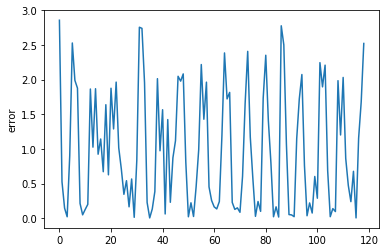

In [17]:
import matplotlib.pyplot as plt
plt.plot(error_list)
plt.ylabel('error')
plt.show()

In [18]:
# loop for number of days with error < 0.5
count = 0
error_df = pd.DataFrame()
for i in range(len(error_list)):
    if(error_list[i] < 0.5):
        error_df['iteration'] = i
        error_df['error'] = error_list[i]
        count = count+1
    
print("count",count)
print("length of error",len(error_df))
print("length of errorlist", len(error_list))

count 47
length of error 0
length of errorlist 119


In [19]:
#try with epochs,iterations and different train ,test sample sizes

In [23]:
%%time
# Loop over all customers
for cust in df['client_debtor_number'].unique():
    df_cust = df[df['client_debtor_number'] == cust]
    del df_cust['client_debtor_number']
    df_cust['dates'] = pd.to_datetime(df_cust['dates'],format= '%d/%m/%Y')
    # splitting train and test datasets 
    #training 2010-2017, testing on 2018 data\
    train_x = df_cust[df_cust['dates'].dt.year == 2018]
    test_x = df_cust[~(df_cust['dates'].dt.year == 2018)]
    #resetting index values
    train_x.reset_index(drop=True,inplace=True)
    test_x.reset_index(drop=True,inplace=True)
    #sorting data based on dates
    train_x['dates'] = pd.to_datetime(train_x['dates'],format= '%d/%m/%Y')
    train_x.sort_values(by='dates',inplace=True)
    test_x['dates'] = pd.to_datetime(test_x['dates'],format= '%d/%m/%Y')
    test_x.sort_values(by='dates',inplace=True)
    # preparing data on train and test fv_cost column values
    train_x_cust,train_y_cust, scalar_train = prepare_training_data(train_x['fv_cost'], 3)
    test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_x['fv_cost'], 3)
    model = lstm_model(train_x_cust,train_y_cust,3,50)
    # we can change training window months later
    train_6m = df_cust[(df_cust['dates'].dt.year == 2018) & 
                      ~((df_cust['dates'].dt.month == 7)|
                      (df_cust['dates'].dt.month == 8)|
                      (df_cust['dates'].dt.month == 9))]
    window_test_3m = df_cust[(df_cust['dates'].dt.year == 2018) &
                            ((df_cust['dates'].dt.month == 7)|
                            (df_cust['dates'].dt.month == 8)|
                            (df_cust['dates'].dt.month == 9))]
    #iteratively run the model on predicitons
    data_train = train_6m['fv_cost']
    data_train.reset_index(drop=True,inplace=True)
    train_x_cust,train_y_cust, scalar_train = prepare_training_data(data_train, 3)
    pred_train = model.predict(train_x_cust,batch_size=1)
    test_fvcost = window_test_3m['fv_cost']
    test_fvcost.reset_index(drop=True,inplace=True)
    test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_fvcost,3)
    test_pred = model.predict(test_x_cust,batch_size=1)
    #since input should be in 3 lag format
    pred_test = np.vstack([pred_train[-3:],test_pred[1]]) 
    n=120
    error_list = []
    error_df = pd.DataFrame()
    for i in range(1,n):
        train_x_cust,train_y_cust, scalar_train = prepare_training_data(pred_train, 3)
        test_x_cust,test_y_cust,scalar_test = prepare_training_data(pred_test, 3)
        model_pred = lstm_model(train_x_cust,train_y_cust,3,50)
        pred_2 = model.predict(test_x_cust,batch_size=1)
        error_list.append(mean_squared_error(test_y_cust,pred_2))
        error_df['iteration'] = i
        error_df['error'] = mean_squared_error(test_y_cust,pred_2)
        error_df['client_number'] = cust
        print("Error at iteration ",i,mean_squared_error(test_y_cust,pred_2))
        #update train and test datasets
        pred_train=np.vstack([pred_train[i:],pred_test])
        pred_test = np.vstack([pred_train[-3:],pred_2]) #input need to have 3 lags
        print ("prediction at ",i,pred_2)
    error_df.to_csv("predictions_futurevalue/predictions_for_"+str(cust)+".csv")
    print("completed loop for customer ",cust)


/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

Epoch 1/10
 - 44s - loss: 0.0863
Epoch 2/10
 - 7s - loss: 0.0994
Epoch 3/10
 - 7s - loss: 0.0423
Epoch 4/10
 - 7s - loss: 0.0290
Epoch 5/10
 - 8s - loss: 0.0285
Epoch 6/10
 - 8s - loss: 0.0244
Epoch 7/10
 - 7s - loss: 0.0257
Epoch 8/10
 - 7s - loss: 0.0281
Epoch 9/10
 - 7s - loss: 0.0220
Epoch 10/10
 - 7s - loss: 0.0260
Epoch 1/10
 - 40s - loss: 0.0418
Epoch 2/10
 - 4s - loss: 0.1035
Epoch 3/10
 - 4s - loss: 0.0526
Epoch 4/10
 - 4s - loss: 0.0219
Epoch 5/10
 - 4s - loss: 0.0130
Epoch 6/10
 - 4s - loss: 0.0193
Epoch 7/10
 - 4s - loss: 0.0153
Epoch 8/10
 - 5s - loss: 0.0189
Epoch 9/10
 - 4s - loss: 0.0172
Epoch 10/10
 - 4s - loss: 0.0195
Error at iteration  1 2.9457283
prediction at  1 [[0.71631217]]
Epoch 1/10
 - 39s - loss: 0.0957
Epoch 2/10
 - 4s - loss: 0.1664
Epoch 3/10
 - 5s - loss: 0.0505
Epoch 4/10
 - 5s - loss: 0.0156
Epoch 5/10
 - 5s - loss: 0.0142
Epoch 6/10
 - 5s - loss: 0.0121
Epoch 7/10
 - 5s - loss: 0.0149
Epoch 8/10
 - 5s - loss: 0.0148
Epoch 9/10
 - 5s - loss: 0.0143
Epo

KeyboardInterrupt: 

In [21]:
# create dataframe with error values <0.1,0.001 and 0.5
error_df.to_csv("predictions_for_client_120daysAhead.csv")  

In [24]:
# cluster error_data customers dataframe
